In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Concatenate, BatchNormalization, Activation,UpSampling2D, GlobalAveragePooling2D, Dense, Reshape, AveragePooling2D
import cv2
import numpy as np

from matplotlib import pyplot as plt
import random

import os

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass


2022-03-04 22:36:34.709629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-04 22:36:34.826020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-04 22:36:34.826731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Dataset

In [2]:
def split_train_test(path = '../input/freihand'):
    dir_list = os.listdir(f'{path}/training/rgb')
    mask_number = len(os.listdir(f'{path}/training/mask'))
        
    random_list = np.random.rand(len(dir_list))
    train_indices = np.where(random_list < 0.7)
    val_indices = np.where(random_list >= 0.7)
        
    return train_indices[0], val_indices[0], mask_number


class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, indices, mask_number,
                 batch_size = 5,
                 input_size = (224,224),
                 shuffle = True, data_augmentation = False):
        self.indices = indices
        self.mask_number = mask_number
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.data_augmentation = data_augmentation
        
        self.imageGenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            horizontal_flip = True,
            vertical_flip = True,
            fill_mode = 'reflect',
            zoom_range = (0.8, 1.1),
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            #rotation_range = 365
        )
        
    def __len__(self):
        return len(self.indices) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.indices)
            
    def __getitem__(self, index):
        
        X = []
        y = []
        
        for i in range(self.batch_size):
            
            image = cv2.imread(f'../input/freihand/training/rgb/{self.indices[self.batch_size * index + i]:08d}.jpg')
            image = cv2.resize(image, (self.input_size[1], self.input_size[0]))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            gt = cv2.imread(f'../input/freihand/training/mask/{self.indices[self.batch_size * index + i] % self.mask_number :08d}.jpg')
            gt = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
            gt = cv2.resize(gt, (self.input_size[1], self.input_size[0]))           
            gt = np.expand_dims(gt, -1)
            
            if self.data_augmentation:
                seed = random.randint(0, 2**32)
                image, gt = self.imageGenerator.random_transform(image, seed), self.imageGenerator.random_transform(gt, seed) 
            X.append(image / 255)
            y.append(gt / 255)
            
        return np.array(X), np.array(y)
    
train_indices, val_indices, mask_number = split_train_test()

train_datagen = CustomDataGen(train_indices, mask_number, data_augmentation = True)
val_datagen = CustomDataGen(val_indices, mask_number)

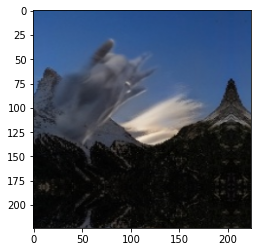

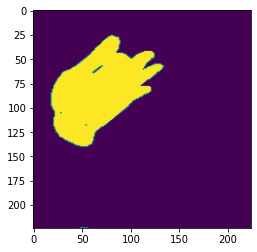

In [3]:
x, y = train_datagen[15012]
plt.imshow(x[0])
plt.show()
plt.imshow(y[0])
plt.show()

# Model

In [4]:
def deeplab_plus(input_size = (224,224, 3), n_classes = 1, output_activation = 'sigmoid'):
    def SqueezeAndExcite(inputs, ratio=8):
        init = inputs
        filters = init.shape[-1]
        se_shape = (1, 1, filters)

        se = GlobalAveragePooling2D()(init)
        se = Reshape(se_shape)(se)
        se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
        se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
        x = init * se
        return x

    def ASPP(inputs):
        """ Image Pooling """
        shape = inputs.shape
        y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
        y1 = Conv2D(256, 1, padding="same", use_bias=False)(y1)
        y1 = BatchNormalization()(y1)
        y1 = Activation("relu")(y1)
        y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

        """ 1x1 conv """
        y2 = Conv2D(256, 1, padding="same", use_bias=False)(inputs)
        y2 = BatchNormalization()(y2)
        y2 = Activation("relu")(y2)

        """ 3x3 conv rate=6 """
        y3 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=6)(inputs)
        y3 = BatchNormalization()(y3)
        y3 = Activation("relu")(y3)

        """ 3x3 conv rate=12 """
        y4 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=12)(inputs)
        y4 = BatchNormalization()(y4)
        y4 = Activation("relu")(y4)

        """ 3x3 conv rate=18 """
        y5 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=18)(inputs)
        y5 = BatchNormalization()(y5)
        y5 = Activation("relu")(y5)

        y = Concatenate()([y1, y2, y3, y4, y5])
        y = Conv2D(256, 1, padding="same", use_bias=False)(y)
        y = BatchNormalization()(y)
        y = Activation("relu")(y)

        return y
        
    
    """ Input """
    inputs = tf.keras.Input(input_size)

    """ Encoder """
    encoder = tf.keras.applications.resnet_v2.ResNet101V2(weights="imagenet", include_top=False, input_tensor=inputs)

    image_features = encoder.get_layer("conv4_block22_out").output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    x_b = encoder.get_layer("conv2_block2_out").output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])
    x = SqueezeAndExcite(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SqueezeAndExcite(x)

    x = UpSampling2D((4, 4), interpolation="bilinear")(x)
    x = Conv2D(n_classes, 1, activation = output_activation)(x)

    model = tf.keras.Model(inputs, x)
    return model

def EncoderMiniBlock(inputs, n_filters = 64, dropout_prob = 0.3, max_pooling = True):
    conv = tf.keras.layers.Conv2D(n_filters, 3, activation = 'relu', padding = 'same', kernel_initializer='HeNormal')(inputs)
    conv = tf.keras.layers.Conv2D(n_filters, 3, activation = 'relu', padding = 'same', kernel_initializer='HeNormal')(conv)
    #conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D()(conv)
    else:
        next_layer = conv
        
    next_connection = conv
    return next_layer, next_connection

#UNET
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters = 64):
    up = tf.keras.layers.Conv2DTranspose(n_filters, 3, strides = (2,2), padding = 'same')(prev_layer_input)
    merge = tf.keras.layers.Concatenate()([up, skip_layer_input])
    
    conv = tf.keras.layers.Conv2D(n_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'HeNormal')(merge)
    conv = tf.keras.layers.Conv2D(n_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'HeNormal')(conv)
    
    return conv
    
def get_model(input_size = (224,224,3), n_classes = 1):
    
    inputs = tf.keras.Input(input_size)
    
    conv1, skip1 = EncoderMiniBlock(inputs)
    conv2, skip2 = EncoderMiniBlock(conv1, n_filters = 128)
    conv3, skip3 = EncoderMiniBlock(conv2, n_filters = 256)
    conv4, skip4 = EncoderMiniBlock(conv3, n_filters = 512)
    conv5, skip5 = EncoderMiniBlock(conv4, n_filters = 1024, max_pooling=False)
    
    level4 = DecoderMiniBlock(conv5, skip4, n_filters = 512)
    level3 = DecoderMiniBlock(level4, skip3, n_filters = 256)
    level2 = DecoderMiniBlock(level3, skip2, n_filters = 128)
    level1 = DecoderMiniBlock(level2, skip1, n_filters = 64)
    
    outputs = tf.keras.layers.Conv2D(n_classes, 1, activation = 'sigmoid')(level1)
    
    return tf.keras.Model(inputs = inputs, outputs = outputs)

# Metric

In [5]:
class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight = None):
        return super().update_state(y_true, tf.where(y_pred > 0.5, 1, 0), sample_weight)

# Training

In [6]:
#tf.keras.applications.resnet_v2.ResNet101V2(weights=None, include_top=False, input_tensor=tf.keras.Input((128,128,3))).summary()

2022-03-04 22:36:39.314194: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-04 22:36:39.315194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-04 22:36:39.315945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-04 22:36:39.316639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Epoch 1/25


2022-03-04 22:36:43.258460: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:801] layout failed: Invalid argument: Size of values 0 does not match size of permutation 4 @ fanin shape inSelectV2-1-TransposeNHWCToNCHW-LayoutOptimizer
2022-03-04 22:36:44.814951: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5000/5000 [==============================] - ETA: 0s - loss: 0.1505 - mean_iou: 0.7135 - recall: 0.5605 - precision: 0.8020

2022-03-04 22:49:56.269009: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:801] layout failed: Invalid argument: Size of values 0 does not match size of permutation 4 @ fanin shape inSelectV2-1-TransposeNHWCToNCHW-LayoutOptimizer


5000/5000 [==============================] - 845s 167ms/step - loss: 0.1505 - mean_iou: 0.7135 - recall: 0.5605 - precision: 0.8020 - val_loss: 0.1455 - val_mean_iou: 0.7884 - val_recall: 0.7269 - val_precision: 0.8262
Epoch 2/25
5000/5000 [==============================] - 867s 173ms/step - loss: 0.1043 - mean_iou: 0.7773 - recall: 0.6828 - precision: 0.8748 - val_loss: 0.1039 - val_mean_iou: 0.7711 - val_recall: 0.5615 - val_precision: 0.9386
Epoch 3/25
5000/5000 [==============================] - 840s 168ms/step - loss: 0.0919 - mean_iou: 0.7941 - recall: 0.7129 - precision: 0.8939 - val_loss: 0.1013 - val_mean_iou: 0.7757 - val_recall: 0.5628 - val_precision: 0.9478
Epoch 4/25
5000/5000 [==============================] - 839s 168ms/step - loss: 0.0831 - mean_iou: 0.8039 - recall: 0.7319 - precision: 0.9045 - val_loss: 0.0809 - val_mean_iou: 0.8270 - val_recall: 0.7651 - val_precision: 0.8857
Epoch 5/25
5000/5000 [==============================] - 868s 173ms/step - loss: 0.0771 - me

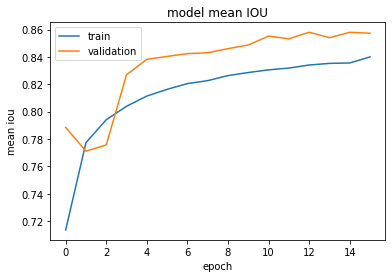

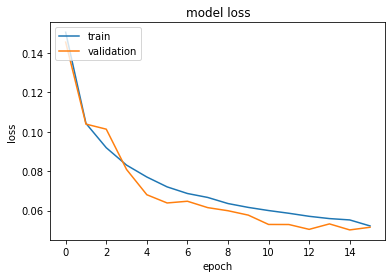

In [7]:
model = get_model()

@tf.function
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return 1 - numerator / denominator

model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
              metrics = [MyMeanIOU(2, name='mean_iou'), 
                        tf.keras.metrics.Recall(thresholds = 0.5, name='recall'),
                        tf.keras.metrics.Precision(thresholds = 0.5, name='precision')])


cp = tf.keras.callbacks.ModelCheckpoint('best.h5', monitor = 'val_mean_iou', mode = 'max')
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 2, verbose = 1, factor = 0.2, min_delta = 1e-3)
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 1e-3, patience = 3)
remote_monitor_callback = tf.keras.callbacks.RemoteMonitor(
        root='https://dweet.io', path='/dweet/for/hand-segmentation-training',
        send_as_json=False, field = 'data'
) #this is to check the training progress while executing the notebook

history = model.fit(train_datagen, 
          steps_per_epoch = 5000,#len(train_datagen), 
          validation_data = val_datagen, 
          validation_steps = 1000,#len(val_datagen),
          callbacks = [cp, learning_rate_reduction, es, remote_monitor_callback],
          epochs = 25, workers=4
          )

plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('model mean IOU')
plt.ylabel('mean iou')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('miou.jpg')
plt.show()
    
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('loss.jpg')
plt.show()

model.load_weights('best.h5')

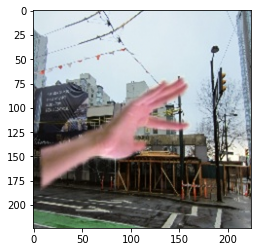

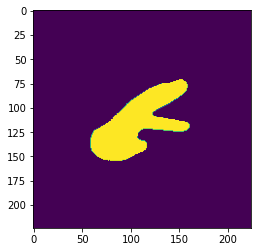

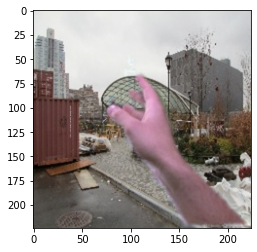

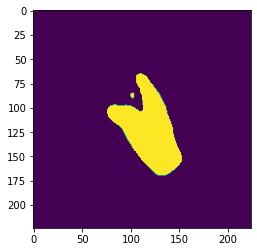

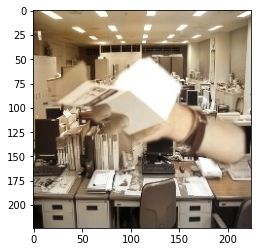

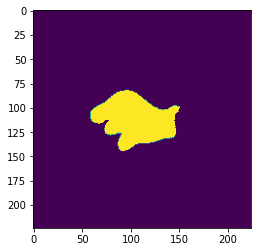

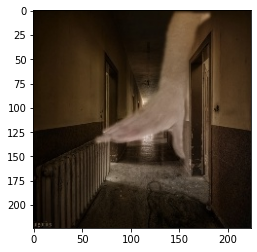

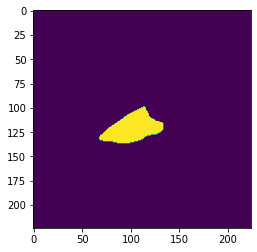

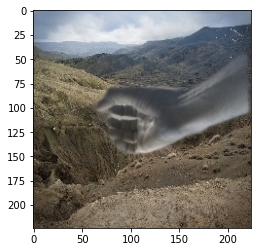

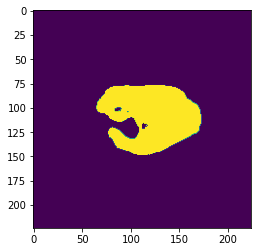

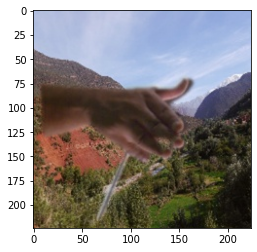

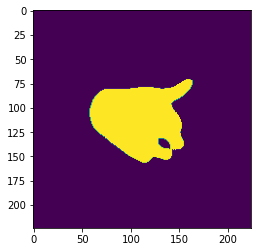

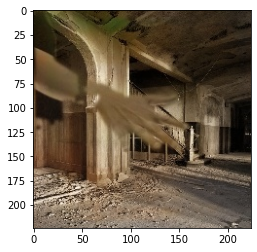

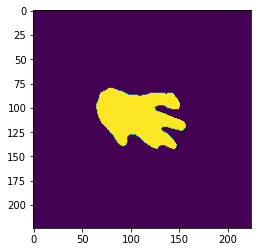

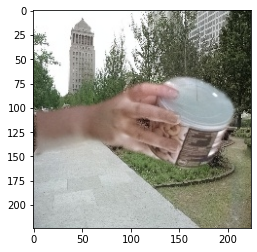

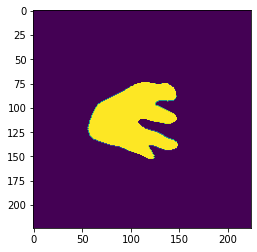

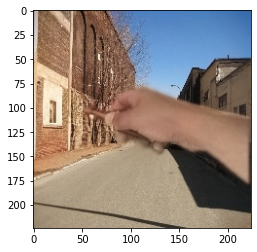

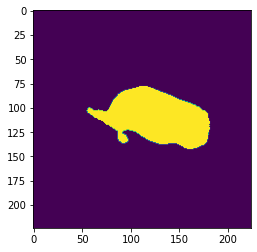

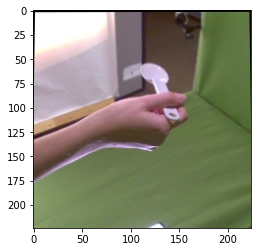

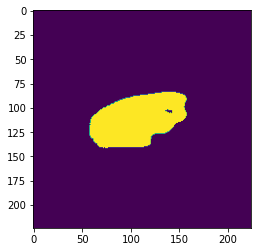

In [8]:
for index in range(5000,5002):
    x, y = val_datagen[index]
    pred = model.predict(x)
    for x_sample, y_sample, pred in zip(x, y, pred):
        plt.imshow(x_sample)
        plt.show()
        plt.imshow(pred > 0.5)
        plt.show()